In [232]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta, datetime
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense, Dropout
# EarlyStopping during model training
from keras.callbacks import EarlyStopping
# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler








#keep these handy
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)



df = pd.read_csv('engineered.csv')

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 39 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   shortdate     49 non-null     object 
 1   Close         49 non-null     float64
 2   Diff          49 non-null     float64
 3   dt            49 non-null     int64  
 4   rocket        49 non-null     int64  
 5   gem           49 non-null     int64  
 6   clown         49 non-null     int64  
 7   joy           49 non-null     int64  
 8   hands         49 non-null     int64  
 9   bear          49 non-null     int64  
 10  gorilla       49 non-null     int64  
 11  money_face    49 non-null     int64  
 12  rofl          49 non-null     int64  
 13  rainbow       49 non-null     int64  
 14  flex          49 non-null     int64  
 15  cry           49 non-null     int64  
 16  think         49 non-null     int64  
 17  smile         49 non-null     int64  
 18  fire          49 non-null     in

In [234]:
df = df.set_index('shortdate') 

In [235]:
print(df.index)

Index(['2021-02-01', '2021-02-02', '2021-02-03', '2021-02-08', '2021-02-09',
       '2021-02-10', '2021-02-11', '2021-02-16', '2021-02-17', '2021-02-18',
       '2021-02-19', '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
       '2021-02-26', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
       '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
       '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-29', '2021-03-30',
       '2021-03-31', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
       '2021-04-09', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19',
       '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-26',
       '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'],
      dtype='object', name='shortdate')


In [236]:



# Indexing Batches
train_df = df.sort_values(by=['shortdate']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,Close,Diff,dt,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,Month,Year
0,839.809998,25.520020,1165,75,34,1,7,19,5,5,1,2,9,10,1,3,2,1,2,1,1,0,2,5,9,3,1,0,8,23,6,11,1,0,6,2,0,1,02,2021
1,872.789978,28.109985,1670,85,44,3,16,26,6,9,8,3,8,13,2,2,1,3,3,1,5,1,1,6,23,12,2,0,3,29,9,16,1,2,9,7,0,1,02,2021
2,854.690002,-22.330017,1060,59,44,6,7,30,6,7,0,1,5,20,1,0,1,1,2,1,1,0,2,3,11,8,5,0,3,6,4,8,1,3,5,5,0,0,02,2021
3,863.419983,-6.250000,730,11,3,0,8,1,1,1,1,1,0,0,2,1,2,0,2,0,1,0,0,4,6,6,1,0,3,7,3,5,0,1,1,3,0,1,02,2021
4,849.460022,-5.659973,765,21,5,4,3,2,3,2,1,1,2,0,1,1,2,1,4,0,1,0,1,5,4,6,2,1,1,6,8,2,0,1,3,1,0,1,02,2021


In [237]:
date_index

Index(['2021-02-01', '2021-02-02', '2021-02-03', '2021-02-08', '2021-02-09',
       '2021-02-10', '2021-02-11', '2021-02-16', '2021-02-17', '2021-02-18',
       '2021-02-19', '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25',
       '2021-02-26', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
       '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12',
       '2021-03-15', '2021-03-16', '2021-03-17', '2021-03-29', '2021-03-30',
       '2021-03-31', '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
       '2021-04-09', '2021-04-14', '2021-04-15', '2021-04-16', '2021-04-19',
       '2021-04-20', '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-26',
       '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'],
      dtype='object', name='shortdate')

In [238]:
# List of considered Features
FEATURES = ['Close','Diff','dt','rocket','gem','clown','joy','hands','bear','gorilla','money_face','rofl','rainbow','flex','cry','think','smile','fire','eyes','upchart','pray','downchart','mbag','FD','DD','YOLO','ATH','HODL','DFV','MOON','STONKS','TENDIES','GAYBEARS','BAGHOLDER','DIAMONDHANDS','PAPERHANDS','JPOW','DEGENERATES']

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'Diff', 'dt', 'rocket', 'gem', 'clown', 'joy', 'hands', 'bear', 'gorilla', 'money_face', 'rofl', 'rainbow', 'flex', 'cry', 'think', 'smile', 'fire', 'eyes', 'upchart', 'pray', 'downchart', 'mbag', 'FD', 'DD', 'YOLO', 'ATH', 'HODL', 'DFV', 'MOON', 'STONKS', 'TENDIES', 'GAYBEARS', 'BAGHOLDER', 'DIAMONDHANDS', 'PAPERHANDS', 'JPOW', 'DEGENERATES']


,Close,Diff,dt,rocket,gem,clown,joy,hands,bear,gorilla,money_face,rofl,rainbow,flex,cry,think,smile,fire,eyes,upchart,pray,downchart,mbag,FD,DD,YOLO,ATH,HODL,DFV,MOON,STONKS,TENDIES,GAYBEARS,BAGHOLDER,DIAMONDHANDS,PAPERHANDS,JPOW,DEGENERATES,Prediction
44,738.200012,-2.799988,1192,12,3,5,3,1,2,0,3,2,1,0,2,1,3,1,1,2,3,1,0,8,2,14,1,0,1,11,1,4,0,0,0,1,1,0,738.200012
45,704.739990,-13.220032,682,13,3,4,2,1,1,0,0,4,1,0,4,2,0,0,1,1,1,0,2,10,1,4,2,0,0,1,1,2,0,1,0,0,0,0,704.739990
46,694.400024,-2.009949,492,8,3,5,3,0,2,2,0,2,1,0,1,1,0,0,0,2,1,2,0,4,3,2,0,0,0,4,1,1,0,4,0,0,2,0,694.400024
47,677.000000,-22.510010,649,16,5,7,5,1,1,5,2,2,2,1,2,2,2,1,3,0,2,0,3,2,8,3,1,0,0,7,0,2,0,1,0,0,0,0,677.000000
48,709.440002,41.849976,121,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,709.440002


In [239]:

# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(49, 38)


In [241]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 20 # = number of neurons in the first layer of the neural network

# Prediction Index
index_Close = 0

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_Close_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_Close_scaled[0:train_data_len, :]
test_data = np_Close_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(20, 20, 1) (20,)
(9, 20, 1) (9,)
0.0
0.0


In [242]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

20 20 1


In [243]:
# Training the model
epochs = 15
batch_size = 7
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/15
3/3 [==============================] - 1s 327ms/step - loss: 0.1341 - val_loss: 0.1476
Epoch 2/15
3/3 [==============================] - 0s 17ms/step - loss: 0.0818 - val_loss: 0.0771
Epoch 3/15
3/3 [==============================] - 0s 18ms/step - loss: 0.0396 - val_loss: 0.0281
Epoch 4/15
3/3 [==============================] - 0s 17ms/step - loss: 0.0243 - val_loss: 0.0077
Epoch 5/15
3/3 [==============================] - 0s 16ms/step - loss: 0.0320 - val_loss: 0.0058
Epoch 6/15
3/3 [==============================] - 0s 17ms/step - loss: 0.0360 - val_loss: 0.0060
Epoch 7/15
3/3 [==============================] - 0s 15ms/step - loss: 0.0289 - val_loss: 0.0085
Epoch 8/15
3/3 [==============================] - 0s 18ms/step - loss: 0.0247 - val_loss: 0.0147
Epoch 9/15
3/3 [==============================] - 0s 16ms/step - loss: 0.0235 - val_loss: 0.0203
Epoch 10/15
3/3 [==============================] - 0s 15ms/step - loss: 0.0238 - val_loss: 0.0224
Epoch 11/15
3/3 [===========

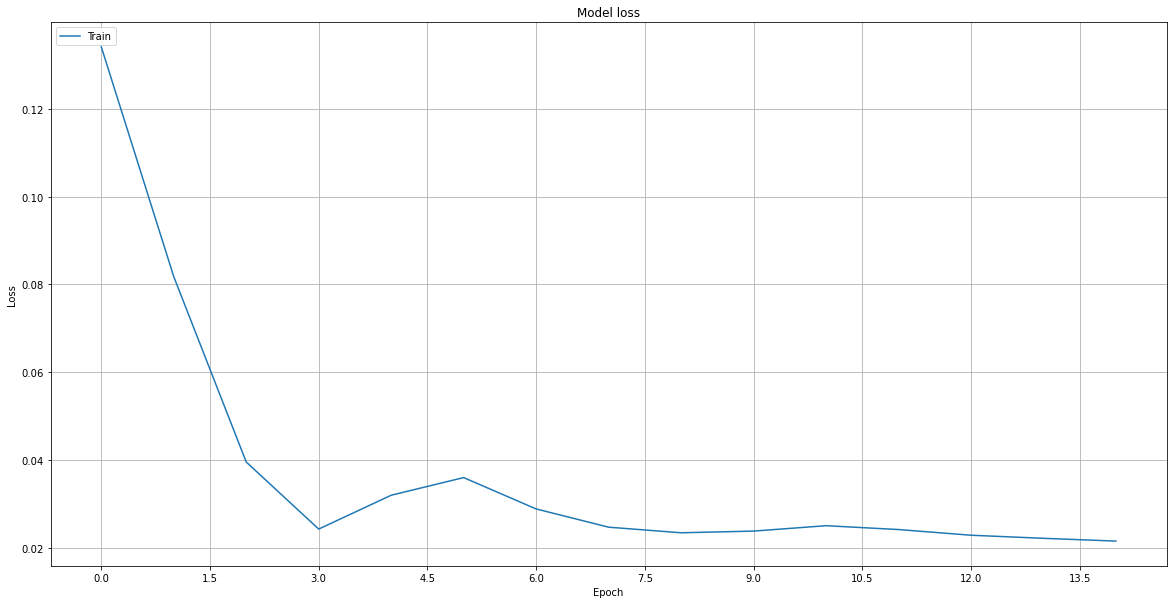

In [244]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [245]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 27.33
Mean Absolute Percentage Error (MAPE): 3.77 %
Median Absolute Percentage Error (MDAPE): 4.13 %


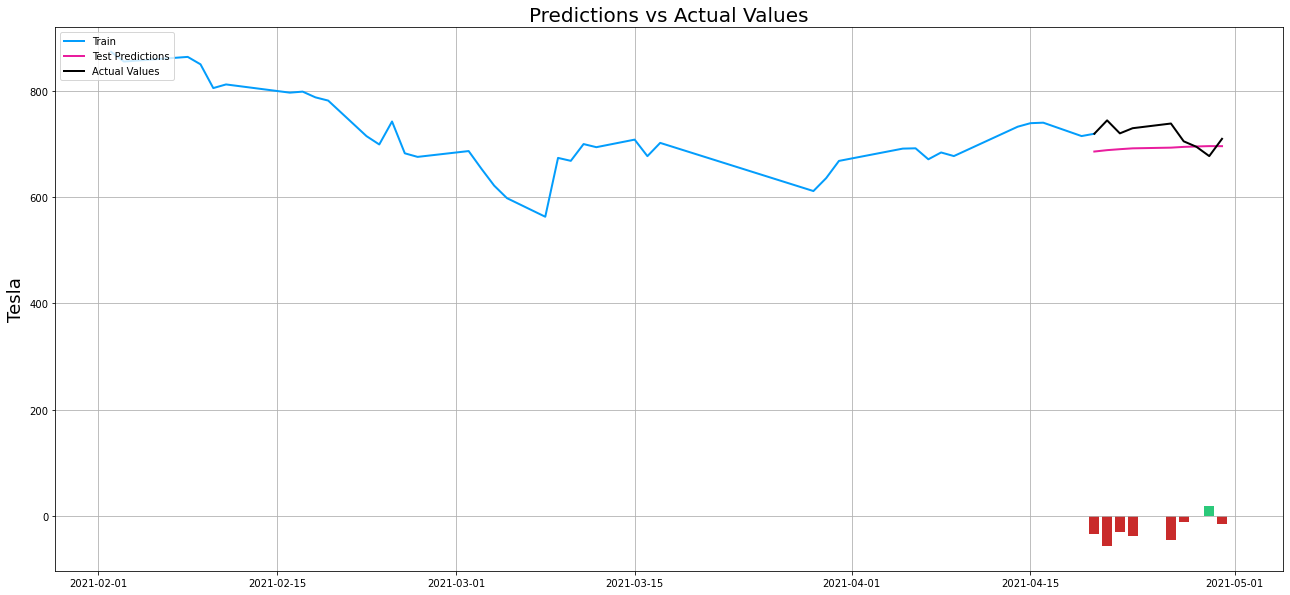

In [246]:
stockname = 'Tesla'
symbol = '^TSLA'



# The start date 

display_start_date = pd.Timestamp(2021,2,1)




# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = pd.to_datetime(date_index, format='%Y-%m-%d')



# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {today} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')


In [ ]:
data_filtered_sub.info()

In [ ]:
display_start_date